In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

import utils

Using TensorFlow backend.


In [2]:
batch_size = 128
epochs = 25
num_classes = 10
patience = num_classes // 5

dimx, dimy = 28, 28

val_split = 0.1  # set to 0 for no val

In [8]:
train = pd.read_csv(str(utils.DATA_DIR / 'train.csv'))
test = pd.read_csv(str(utils.DATA_DIR / 'test.csv'))

In [9]:
y_train = train.pop('label')
X_train = train

# normalize
X_train = X_train / 255.0
test = test / 255.0

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes=10)

In [10]:
X_train = X_train.values.reshape(X_train.shape[0],dimx, dimy, 1)
test = test.values.reshape(test.shape[0],dimx, dimy, 1)

In [11]:
input_shape = (dimx, dimy, 1)  # (x, y, channels) only greyscale -> 1 channel

In [12]:
model = keras.models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


# finally pass through ffn
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))


model.compile(
    optimizer=keras.optimizers.Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [21]:
# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[early_stop]
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/25
37800/37800 [==============================] - 3s 67us/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.0315 - val_accuracy: 0.9914
Epoch 2/25
37800/37800 [==============================] - 3s 67us/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0416 - val_accuracy: 0.9907
Epoch 3/25
37800/37800 [==============================] - 3s 67us/step - loss: 0.0139 - accuracy: 0.9954 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 4/25
37800/37800 [==============================] - 2s 66us/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.0341 - val_accuracy: 0.9902
Epoch 5/25
37800/37800 [==============================] - 2s 66us/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0348 - val_accuracy: 0.9902


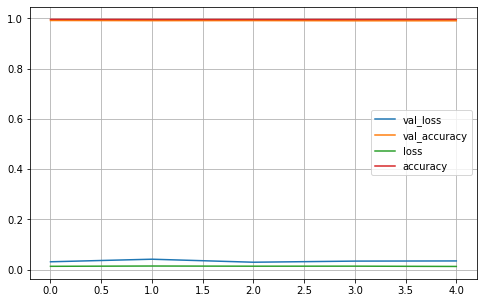

In [23]:
source = pd.DataFrame(history.history)
source.plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [16]:
el = X_train[45]

y_proba = model.predict_classes(el.reshape(1, *el.shape))
y_proba

array([6], dtype=int64)

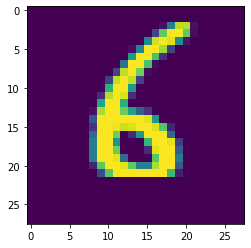

In [17]:
plt.imshow(el.reshape(dimx, dimy))

In [18]:
results = model.predict_classes(test)
results = pd.Series(results,name="Label")

In [19]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(results)+1)), "Label": results})
submissions.to_csv("mnist_results.csv", index=False, header=True)